<a href="https://colab.research.google.com/github/akash-agni/DeepLearning/blob/main/Car_Type_Object_Detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle datasets download -d jessicali9530/stanford-cars-dataset
! wget "https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz"

100% 1.82G/1.82G [00:20<00:00, 102MB/s]
100% 1.82G/1.82G [00:20<00:00, 94.1MB/s]
--2021-03-28 12:58:26--  https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330960 (323K) [application/x-gzip]
Saving to: ‘car_devkit.tgz’

car_devkit.tgz      100%[===================>] 323.20K  1.74MB/s    in 0.2s    

2021-03-28 12:58:26 (1.74 MB/s) - ‘car_devkit.tgz’ saved [330960/330960]



In [3]:
! mkdir ./data
! unzip stanford-cars-dataset.zip -d ./data > extract.log
! tar -xf car_devkit.tgz
! rm -rf stanford-cars-dataset.zip car_devkit.tgz

In [1]:
import os, time
import numpy as np
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import pandas as pd
from PIL import Image
from scipy.io import loadmat
import cv2
from google.colab.patches import cv2_imshow

from torchvision.transforms import functional as F
from torchvision import transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn import metrics as mtr
from torchvision.transforms import ToTensor

In [2]:
class cars_data:

  def __init__(self, root, split, transforms=None):
    self.data_dir = None
    assert split in ['train', 'test']
    
    if split == 'train':
      self.data_dir = os.path.join(root, 'cars_train', 'cars_train')
    elif split == 'test':
      self.data_dir = os.path.join(root, 'cars_test', 'cars_test')
    self.imgs = list(sorted(os.listdir(self.data_dir)))

    label_file = "/content/devkit/cars_train_annos.mat"
    annot = loadmat(label_file)['annotations'][0]
    self.label_data = pd.DataFrame([[i.flat[0] for i in line] for line in annot])
    self.label_data.columns = ['x1', 'x2', 'y1', 'y2', 'class', 'fname']
    
    self.classes = loadmat("/content/devkit/cars_meta.mat")['class_names'][0]
    self.classes = [i.flat[0] for i in self.classes]

    self.transforms = transforms
  
  def __len__(self):
    return len(self.imgs)

  def class_to_label(self, idx):
    return self.classes[idx]
  
  def __getitem__(self, idx):
    img_path = os.path.join(self.data_dir, self.imgs[idx])
    img = F.to_tensor(Image.open(img_path).convert('RGB'))
    boxes = list()
    labels = list()

    ld = np.array(self.label_data[self.label_data['fname'] == self.imgs[idx]])
    for row in ld:
      xmin = float(row[0])
      ymin = float(row[1])
      xmax = float(row[2])
      ymax = float(row[3])
      boxes.append([xmin, ymin, xmax, ymax])
      labels.append(1)
    
    boxes = torch.as_tensor(boxes)
    labels = torch.tensor(labels)
    image_id = torch.tensor([idx])
    is_crowd = torch.zeros((len(ld,)), dtype=torch.int64)
    area = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])

    target = dict()
    target['boxes'] = boxes
    target['labels'] = labels
    target['image_id'] = image_id
    target['iscrowd'] = is_crowd
    target['area'] = area

    if self.transforms is not None:
      img = self.transforms(img)

    return img, target

In [3]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [4]:
dataset = cars_data("/content/data", 'train')

train_data = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True,
                                         collate_fn=lambda x: tuple(zip(*x)))

In [5]:
dataset[1]

(tensor([[[0.6431, 0.6510, 0.6627,  ..., 1.0000, 1.0000, 1.0000],
          [0.6510, 0.6588, 0.6667,  ..., 1.0000, 1.0000, 1.0000],
          [0.6588, 0.6667, 0.6706,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.6235, 0.5686, 0.5255,  ..., 0.5294, 0.5373, 0.5961],
          [0.6353, 0.5294, 0.4902,  ..., 0.5294, 0.5137, 0.5373],
          [0.6235, 0.5686, 0.5412,  ..., 0.5333, 0.4980, 0.4980]],
 
         [[0.6627, 0.6706, 0.6824,  ..., 1.0000, 1.0000, 1.0000],
          [0.6706, 0.6784, 0.6863,  ..., 1.0000, 1.0000, 1.0000],
          [0.6784, 0.6863, 0.6902,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.6000, 0.5412, 0.4980,  ..., 0.5098, 0.5176, 0.5765],
          [0.6118, 0.5020, 0.4627,  ..., 0.5098, 0.4941, 0.5176],
          [0.6000, 0.5412, 0.5137,  ..., 0.5137, 0.4784, 0.4784]],
 
         [[0.6863, 0.6941, 0.7059,  ..., 1.0000, 1.0000, 1.0000],
          [0.6941, 0.7020, 0.7098,  ..., 1.0000, 1.0000, 1.0000],
          [0.7020, 0.7098, 0.7137,  ...,

In [ ]:
for _ in range(4):
  item = dataset[np.random.randint(len(train_data))]
  frame = np.moveaxis(item[0], 0, -1)*255.0
  boxes = np.array(item[1]['boxes'][0])*255.0
  frame = cv2.rectangle(frame, (boxes[0], boxes[1]), (boxes[2], boxes[3]), (0, 0, 255), 2)
  frame = cv2.putText(frame, dataset.class_to_label(item[1]['labels']), (boxes[0], boxes[1]),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
  cv2_imshow(frame)
  print('\n')

In [6]:
def get_frcnn_model(num_classes):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes+1)
  return model

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = get_frcnn_model(1).to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 1

In [8]:
model.train()
for i in range(num_epochs):
    j = -1
    print(f"Epoch: {i}/{num_epochs}")
    for images, targets in train_data:
      j += 1
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
      loss_dict = model(images, targets)
      losses = sum(loss for loss in loss_dict.values())
      optimizer.zero_grad()
      losses.backward()
      optimizer.step()

      if j%10 == 0:
        print(f"Loss: {losses.item()}")
      
      del images, targets, losses
      torch.cuda.empty_cache()

Epoch: 0/1
Loss: 1.0367501974105835
Loss: 0.1413547694683075
Loss: 0.13723251223564148
Loss: 0.07781479507684708
Loss: 0.07130008935928345
Loss: 0.06313817948102951
Loss: 0.06431703269481659
Loss: 0.05409716069698334
Loss: 0.05075868219137192
Loss: 0.0463833212852478
Loss: 0.0476948618888855
Loss: 0.04057244956493378
Loss: 0.03834417089819908
Loss: 0.0421014130115509
Loss: 0.0434495210647583
Loss: 0.04415813833475113
Loss: 0.044855669140815735
Loss: 0.03139357641339302
Loss: 0.05293172970414162
Loss: 0.034827589988708496
Loss: 0.03489702194929123
Loss: 0.040773212909698486
Loss: 0.03535579517483711
Loss: 0.03352949023246765
Loss: 0.038920022547245026


KeyboardInterrupt: ignored

In [9]:
@torch.no_grad()
def evaluate(model, data):
  model = model.eval()
  model.to('cpu')
  preds = model([data])
  return preds

In [10]:
def load_custom_img(path):
  img = F.to_tensor(Image.open(path).convert('RGB'))
  return img

In [13]:
img = load_custom_img("/content/M8.jpg")
pred = evaluate(model, img)
pred

[{'boxes': tensor([[ 35.2466,  62.9763, 224.2338, 144.7175]]),
  'labels': tensor([1]),
  'scores': tensor([0.9994])}]

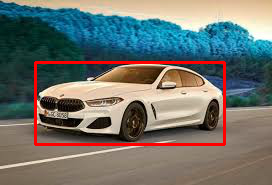

In [14]:
frame = img.numpy()*255.0
frame = np.moveaxis(frame, 0, -1)
boxes = list(pred[0]['boxes'][0].numpy())
frame = cv2.rectangle(frame, (boxes[0], boxes[1]), (boxes[2], boxes[3]), (0, 0, 255), 2).get()
cv2_imshow(frame)